
### Imports

In [1]:
%pylab inline
import polybin as pb
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


### Options

In [2]:
Nside = 128
lmax = 3*Nside-1
print("lmax: %d"%lmax)

# Binning parameters
dl = 30 # width
Nl = 10 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations
N_it = 20

# Number of simulations to use for testing
N_sim = 100

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

lmax: 383
binned lmax: 302


### Fiducial Power and Noise Spectrum

In [3]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)
l_arr,m_arr = healpy.Alm.getlm(lmax)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))

# Interpolate to all ell, m grid
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Nl_th_interp = InterpolatedUnivariateSpline(l,Nl_th)
Cl_th_lm = Cl_th_interp(l_arr)
Nl_th_lm = Nl_th_interp(l_arr)

# Zero out ell = 0 and ell = 1
Cl_th_lm[l_arr<2] = 0.
Nl_th_lm[l_arr<2] = 0.

In [4]:
# define separable reduced bispectrum input
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

### Load mask

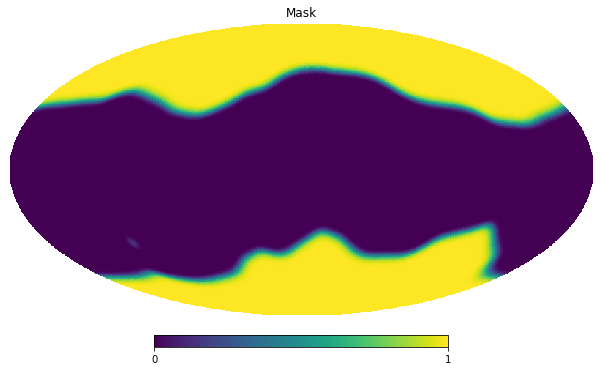

In [5]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Generate Synthetic Data with known $C_\ell$, $b_{\ell_1\ell_2\ell_3}$

**Bispectrum generation**
From Smith & Zaldarriaga (2006):
$$a_{\ell m} \to a_{\ell m}+\frac{1}{3}\nabla_{\ell m}T[C^{-1}_\ell a_{\ell m}]$$
with $\nabla_{\ell m}T[x]$ defined by
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b_{\ell\ell_2\ell_3}\mathcal{G}^{\ell\ell_2\ell_3}_{mm_2m_3}a_{\ell_2m_2}^*a_{\ell_3m_3}^*\\
    &=&\frac{1}{2}b_{\ell\ell_2\ell_3}\int d\hat{n} Y^*_{\ell m}(\hat n)Y^*_{\ell_2m_2}(\hat n)Y^*_{\ell_3m_3}(\hat n)a_{\ell_2m_2}^*a_{\ell_3m_3}^*
\end{eqnarray}
Assuming separable $b_{\ell_1\ell_2\ell_3}$, we can write
\begin{eqnarray}
    \frac{\partial T[a]}{\partial a^*_{\ell m}}&=&\frac{1}{2}b^{(1)}_{\ell}\left[[b^{(2)}a]^*(\hat n)[b^{(3)}a]^*(\hat n)\right]_{\ell m}
\end{eqnarray}
where $[b^{(i)}a](\hat n)$ is real. Notably, this does not satisfy $\langle{a_{\ell m}}\rangle = 0$; in practice, we subtract off a (deterministic) offset to ensure that this condition is obeyed.

In [6]:
# Basic HEALPix utilities
def to_lm(input_map):
    """Convert from map-space to harmonic-space"""
    return healpy.map2alm(input_map,pol=False)

def to_map(input_lm):
    """Convert from harmonic-space to map-space"""
    return healpy.alm2map(input_lm,Nside,pol=False)

def safe_divide(x,y):
    """Function to divide maps without zero errors."""
    out = np.zeros_like(x)
    out[y!=0] = x[y!=0]/y[y!=0]
    return out
    
def generate_data(seed=None,add_B=True,remove_mean=True):
    """Generate a cmb map with a given C_ell and (optionally) b_l1l2l3. 
    
    We use the method of Smith & Zaldarriaga 2006, and assume that b_l1l2l3 is separable into three identical pieces.
    
    We optionally subtract off the mean of the map (numerically, but could be done analytically), since it is not guaranteed to be zero if we include a synthetic bispectrum.
    
    No mask is added at this stage."""
    if seed!=None:
        np.random.seed(seed)
    
    # Generate a_lm
    initial_lm = healpy.synalm(Cl_th+Nl_th,lmax)
    
    if not add_B:
        return to_map(initial_lm)
    
    Cinv_lm = safe_divide(initial_lm,Cl_th_lm+Nl_th_lm)
    bCinv_map = to_map(b_input_fac(l_arr)*Cinv_lm)
    grad_lm = 0.5*b_input_fac(l_arr)*to_lm(bCinv_map*bCinv_map)
    
    output_lm = initial_lm + 1./3.*grad_lm
    output_map = to_map(output_lm)
    
    if remove_mean:
        output_map -= map_offset
        
    return output_map

# Compute mean of synthetic maps numerically
print("Computing offset for synthetic maps")
map_offset = 0.
N_norm = 100
for ii in range(N_norm):
    map_offset += generate_data(int(1e6)+ii,add_B=True,remove_mean=False)/N_norm

Computing offset for synthetic maps


### Generate Synthetic Data

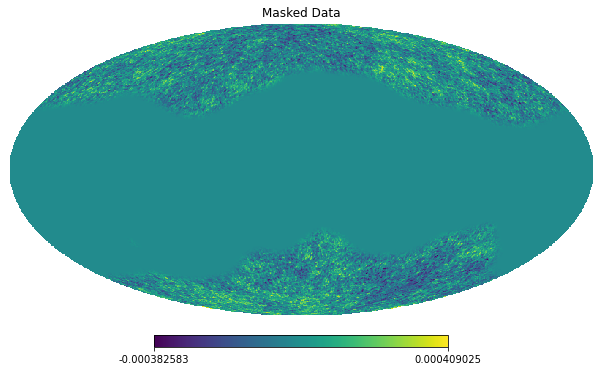

In [7]:
# Generate unmasked data
raw_data = generate_data(add_B=include_synthetic_b)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

# Key Functions

### Creation of $U^{-1}$ weights 

**Ignoring pixel weights**, relation between discrete real- and harmonic-space is
$$a_{\ell m} = \frac{4\pi}{N}\sum_{p}Y_{\ell m}^*(\hat n_p)a(\hat n_p) \quad\leftrightarrow\quad a(\hat n_p) = \sum_{\ell m}Y_{\ell m}(\hat n_p)a_{\ell m}$$
for $N$ pixels.

Thus, the multiplication of two maps is given by
$$\frac{4\pi}{N}\sum_{p}a(\hat n_p)b(\hat n_p) = \sum_{\ell,m\geq 0}a_{\ell m}b^*_{\ell m}\left[1+\delta^{\rm K}_{m>0}\right]$$

We want to create a function $U^{-1}$ that satisfies $\int d\hat n'U^{-1}(\hat n,\hat n')\langle{u(\hat n')u(\hat n'')\rangle} = \delta_{\rm D}(\hat n-\hat n'')$ in continuous space, or, in discrete map-space: $\left(\frac{4\pi}{N}\right)^2\sum_{jk}U^{-1}(\hat n_i,\hat n_j)\langle u(\hat n_j)u(\hat n_k)\rangle \beta(\hat n_k) = \beta(\hat n_i)$ for arbitrary $\beta$ and GRFs $u$. This implies:
\begin{eqnarray}
    U^{-1}(\hat n_i,\hat n_j) =\sum_{\ell m}\frac{1}{C^u_{\ell}}Y_{\ell m}(\hat n_i)Y^*_{\ell m}(\hat n_j)
\end{eqnarray}
A good way to test this is by computing
$$\left(\frac{4\pi}{N}\right)^2\sum_{ij}u(\hat n_i)U^{-1}(\hat n_i,\hat n_j)u(\hat n_j)$$
which should equal $(\ell_{\rm max}+1)^2$, averaging over $u$.

In [8]:
av_sq_mask = np.mean(mask**2)
A_pix = 4.*np.pi/len(mask)
    
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular (C_l + N_l) and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    
    return Cinv_map

def generate_grf(seed):
    """Generate a Gaussian random field with a known (exact) power spectrum, and covariance U.
    
    Here, we assume that the power spectrum is diagonal in ell without a window."""
    # Set seed
    np.random.seed(seed)
    # Generate spectrum
    return healpy.synfast(Cl_th+Nl_th,Nside)

def applyUinv(input_map):
    """Apply the exact inverse weighting U^{-1} to a map."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    output = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    return output

### Compute True Power Spectra

(2.0, 383.0)

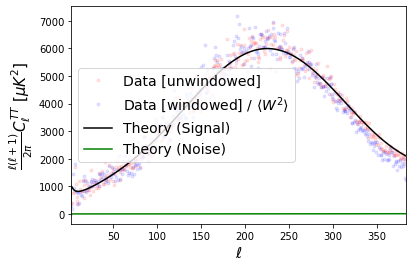

In [9]:
# Compute power spectra
Cl_raw_data = healpy.alm2cl(to_lm(raw_data))
Cl_data = healpy.alm2cl(to_lm(data))/av_sq_mask

# Plot results
pref = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,pref*Cl_raw_data,label='Data [unwindowed]',ls='',marker='.',alpha=0.1,c='r')
plt.plot(l,pref*Cl_data,label=r'Data [windowed] / $\langle W^2\rangle$',ls='',marker='.',alpha=0.1,c='b')
plt.plot(l,pref*Cl_th,label='Theory (Signal)',c='k')
plt.plot(l,pref*Nl_th,label='Theory (Noise)',c='g')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15)
plt.xlim([2,lmax])

### Compute $h\equiv S^{-1}\tilde{a}$ map and $W h\equiv WS^{-1}\tilde a$

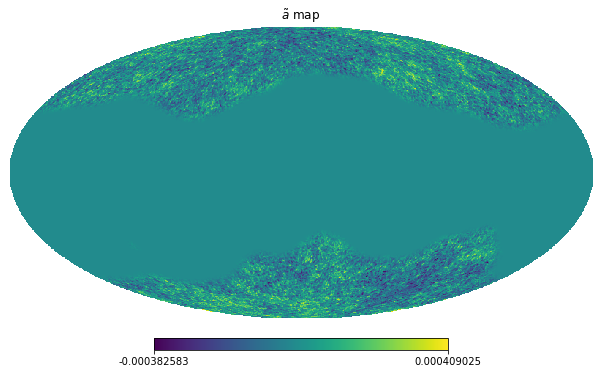

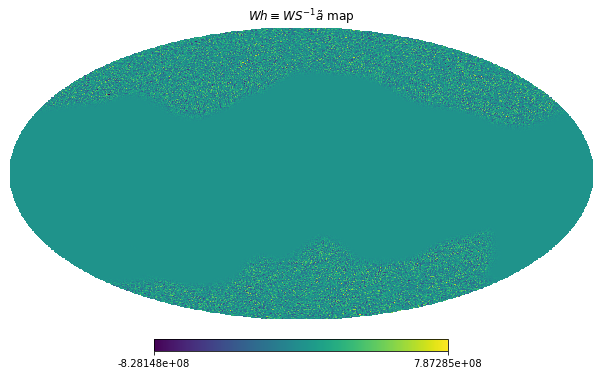

In [10]:
h_data = applySinv(data)
Wh_data = mask*h_data

healpy.mollview(data,title=r'$\tilde{a}$ map')
healpy.mollview(Wh_data,title=r'$Wh\equiv WS^{-1}\tilde{a}$ map')

### Power Spectrum Estimation
The binned power spectrum estimator (including noise) is given by
$$\widehat{C}_b \propto\frac{1}{2}\sum_{\ell,m\geq 0}\Theta_{\ell}(b)[Wh]_{\ell m}[Wh]_{\ell(-m)}(1+\delta^{\rm K}_{m>0})$$
with normalization
$$\mathcal{F}_{bb'} = \frac{1}{2}\langle\int d\hat{n}\,d\hat{n}'[WC_{,b}WA^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')[WC_{,b'}WS^{-1}\alpha](\hat{n}')\rangle_{\alpha}$$
or
$$\mathcal{F}_{bb'} = \frac{1}{2}\langle\int d\hat{n}\,d\hat{n}'Q_b[A^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')Q_b[S^{-1}\alpha](\hat{n}')\rangle_\alpha$$
with
$$Q_b[x](\hat{n}) = [WC_{,b}Wx](\hat{n})$$

In [11]:
# Define ell bins
ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

#### Compute quadratic estimator
Wh_data_lm = to_lm(Wh_data)
Cl_num = [0.5*np.real(np.sum((1.+1.*(m_arr>0.))*Wh_data_lm*np.conj(Wh_data_lm)*ell_bins[i])) for i in range(Nl)]

In [12]:
### Iterate over realizations
fish = np.zeros((Nl,Nl))
for seed in range(N_it):

    ## Compute random realization with known power spectrum
    print("Computing GRF map %d of %d"%(seed+1,N_it))
    u = generate_grf(seed)

    ## Compute weighted fields
    Sinv_u = applySinv(u)
    Uinv_u = applyUinv(u)

    ## Compute Q_b fields
    if seed==0: print("Computing Q_b")
    WSinv_u_lm = to_lm(mask*Sinv_u)
    WUinv_u_lm = to_lm(mask*Uinv_u)
    Q_b_Sinv_u = [to_map(WSinv_u_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]
    Q_b_Uinv_u = [to_map(WUinv_u_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]

    ## Apply S^-1 weighting
    if seed==0: print("Computing S^-1 Q_b")
    Sinv_Q_b_Sinv_u = [applySinv(Q_b_Sinv_u[bin1]) for bin1 in range(Nl)]

    ## Compute the Fisher matrix
    if seed==0: print("Computing Fisher matrix")
    for bin1 in range(Nl):
        for bin2 in range(Nl):
            fish[bin1,bin2] += 0.5*np.real(A_pix*np.sum(Q_b_Uinv_u[bin1]*(Sinv_Q_b_Sinv_u[bin2])))/N_it
        
### Compute full estimator
Cl_est = np.linalg.inv(fish)@Cl_num

Computing GRF map 1 of 20
Computing Q_b
Computing S^-1 Q_b
Computing Fisher matrix
Computing GRF map 2 of 20
Computing GRF map 3 of 20
Computing GRF map 4 of 20
Computing GRF map 5 of 20
Computing GRF map 6 of 20
Computing GRF map 7 of 20
Computing GRF map 8 of 20
Computing GRF map 9 of 20
Computing GRF map 10 of 20
Computing GRF map 11 of 20
Computing GRF map 12 of 20
Computing GRF map 13 of 20
Computing GRF map 14 of 20
Computing GRF map 15 of 20
Computing GRF map 16 of 20
Computing GRF map 17 of 20
Computing GRF map 18 of 20
Computing GRF map 19 of 20
Computing GRF map 20 of 20


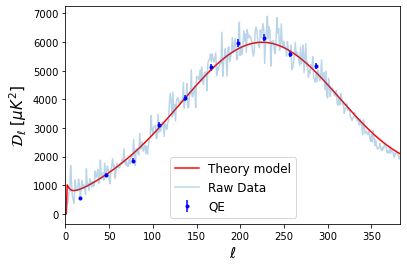

In [13]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(np.linalg.inv(fish)))
plt.errorbar(l_av,pref_av*Cl_est,yerr=pref_av*fish_err,marker='.',ls='',label='QE',c='b')
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.plot(l,pref*Cl_raw_data,label='Raw Data',alpha=0.3)
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)

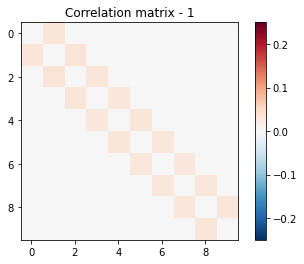

In [14]:
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation matrix - 1")
plt.colorbar();

### Iterate over multiple data-sets

In [15]:
Cl_ests = []
Cl_ests_raw = []

for ii in range(N_sim):
    if ii%10==0: 
        print("Analyzing simulation %d of %d"%(ii+1,N_sim))
    # Generate unmasked data
    raw_data = generate_data(ii,include_synthetic_b)

    # Mask the map
    data = raw_data*mask

    # Filter the data
    h_data = applySinv(data)
    Wh_data = mask*h_data

    # Define ell bins
    ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

    #### Compute quadratic estimator
    Wh_data_lm = to_lm(Wh_data)
    this_Cl_num = [0.5*np.real(np.sum((1.+1.*(m_arr>0.))*Wh_data_lm*np.conj(Wh_data_lm)*ell_bins[i])) for i in range(Nl)]
    
    Cl_ests.append(np.linalg.inv(fish)@this_Cl_num)
    Cl_ests_raw.append(healpy.anafast(raw_data))

Analyzing simulation 1 of 100
Analyzing simulation 11 of 100
Analyzing simulation 21 of 100
Analyzing simulation 31 of 100
Analyzing simulation 41 of 100
Analyzing simulation 51 of 100
Analyzing simulation 61 of 100
Analyzing simulation 71 of 100
Analyzing simulation 81 of 100
Analyzing simulation 91 of 100


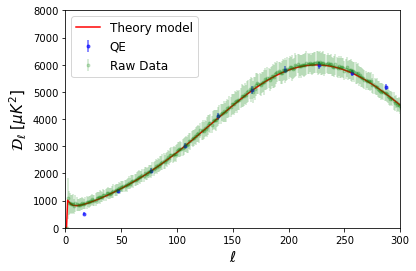

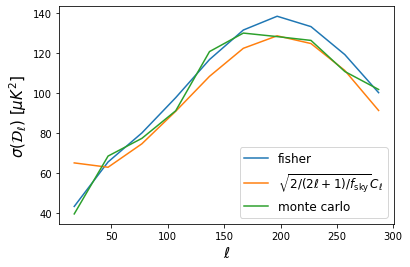

In [16]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(np.linalg.inv(fish)))
plt.errorbar(l_av,pref_av*np.asarray(Cl_ests).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='QE',c='b',alpha=0.6)
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_ests_raw).mean(axis=0),yerr=pref*np.asarray(Cl_ests_raw).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2,c='g')
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([0,300])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='fisher')
f_sky = np.mean(mask)
plt.plot(l_av,pref_av*np.sqrt(2./(2*l_av+1.)/dl/f_sky)*Cl_th_interp(l_av),label=r'$\sqrt{2/(2\ell+1)/f_{\rm sky}}C_\ell$')
plt.plot(l_av,pref_av*np.asarray(Cl_ests).std(axis=0),label='monte carlo')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);

# Bispectrum estimation

### Conventional (binned) estimator

In [17]:
# Compute I maps
I_map_raw = [to_map(ell_bins[bin1]*safe_divide(to_lm(raw_data),Cl_th_lm+Nl_th_lm)) for bin1 in range(Nl)]
I_map = [to_map(ell_bins[bin1]*safe_divide(to_lm(data),Cl_th_lm+Nl_th_lm)) for bin1 in range(Nl)]

def check_bin(bin1,bin2,bin3):
    """Return one if modes in the bin satisfy the even-parity triangle conditions, or zero else.
    
    This is used either for all triangles in the bin, or just the center of the bin.
    """
    if include_partial_triangles:
        good = 0
        for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
            for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                    # skip any odd bins
                    if (-1)**(l1+l2+l3)==-1: continue 
                    if l1>=abs(l1-l2) and l3<=l1+l2:
                        good = 1
                    if good==1: break
                if good==1: break
            if good==1: break
        if good==1: return 1
        else:
            return 0
    else:
        l1 = min_l+(bin1+0.5)*dl
        l2 = min_l+(bin2+0.5)*dl
        l3 = min_l+(bin3+0.5)*dl
        if l3<abs(l1-l2) or l3>l1+l2:
            return 0
        else:
            return 1
        
# Combine to find numerator
b_num_ideal_raw = []
b_num_ideal = []
sym_factor = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
                
            # compute symmetry factor
            if bin1==bin2 and bin2==bin3:
                sym = 6
            elif bin1==bin2 or bin2==bin3:
                sym = 2
            else:
                sym = 1
            sym_factor.append(sym)
                
            # compute numerators
            b_num_ideal_raw.append(A_pix*np.sum(I_map_raw[bin1]*I_map_raw[bin2]*I_map_raw[bin3])/sym)
            b_num_ideal.append(A_pix*np.sum(I_map[bin1]*I_map[bin2]*I_map[bin3])/sym)
            
            
b_num_ideal_raw = np.asarray(b_num_ideal_raw)
b_num_ideal = np.asarray(b_num_ideal)/np.mean(mask**3)
            
# number of bins
N_b = len(b_num_ideal)
print("%d bispectrum bins"%N_b)

125 bispectrum bins


In [18]:
# Load pre-computed 3j symbols
assert lmax<=500, "Higher-l 3j symbols not yet precomputed!"
tj_arr = np.load('/projects/QUIJOTE/Oliver/wig3j_array.npz')

# C+N vector
Sl_vec = [(li>=2)*(Cl_th_interp(li)+Nl_th_interp(li)) for li in l]


# compute denominator
b_denom = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
                
            if (len(b_denom)+1)%25==0: print("Computing bin %d of %d"%(len(b_denom)+1,N_b))
            value = 0.
            
            # Now iterate over l bins
            for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
                for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                    for l3 in range(min_l+bin3*dl,min_l+(bin3+1)*dl):
                        if (-1)**(l1+l2+l3)==-1: continue # 3j = 0 here
                        if l3<abs(l1-l2) or l3>l1+l2: continue
                        tj = tj_arr[l1,l2,l3]
                        value += tj**2*(2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.)/(4.*np.pi)/Sl_vec[l1]/Sl_vec[l2]/Sl_vec[l3]/sym_factor[len(b_denom)]
            b_denom.append(value)
b_denom = np.asarray(b_denom)

b_ideal_raw = b_num_ideal_raw/b_denom
b_ideal = b_num_ideal/b_denom

Computing bin 25 of 125
Computing bin 50 of 125
Computing bin 75 of 125
Computing bin 100 of 125
Computing bin 125 of 125


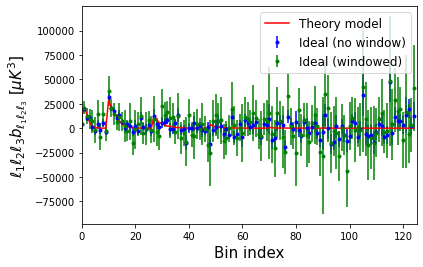

In [19]:
weights = []
bl_model = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue
            weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*1e18)
            bl_model.append(b_input_fac(min_l+(bin1+0.5)*dl)*b_input_fac(min_l+(bin2+0.5)*dl)*b_input_fac(min_l+(bin3+0.5)*dl))
weights = np.asarray(weights)
bl_model = np.asarray(bl_model)
            
fish_err_ideal = np.sqrt(1./b_denom)
plt.errorbar(np.arange(N_b),weights*b_ideal_raw,yerr=weights*fish_err_ideal,marker='.',ls='',label='Ideal (no window)',c='b')
plt.errorbar(np.arange(N_b),weights*b_ideal,yerr=weights*fish_err_ideal/np.mean(mask**3),marker='.',ls='',label='Ideal (windowed)',c='g')
plt.plot(np.arange(N_b),weights*bl_model,label='Theory model',c='r')
plt.xlim([0,N_b])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

### Window-free estimator

In [20]:
#### Compute Q_b terms
print("## Bispectrum data piece")
Wh_data_lm = to_lm(Wh_data)
Q_b_map = [to_map(Wh_data_lm*ell_bins[bin1]) for bin1 in range(Nl)]

### Compute b_3 part of cubic estimator
b3_num = np.zeros(N_b)
b1_num = np.zeros(N_b)
index = 0
print("Computing b_3 piece")
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not check_bin(bin1,bin2,bin3): continue

            # compute numerators
            b3_num[index] = A_pix*np.sum(Q_b_map[bin1]*Q_b_map[bin2]*Q_b_map[bin3])/sym_factor[index]
            index += 1

### Compute b_1 part of cubic estimator, averaging over simulations
for ii in range(N_it):
    if (ii+1)%5==0: print("Computing b_1 piece from simulation %d"%(ii+1))
    # Generate simulations matching true data
    alpha_lm = to_lm(generate_data(seed=10000+ii,add_B=include_synthetic_b))
    Wh_alpha_lm = to_lm(mask*to_map(safe_divide(alpha_lm,Cl_th_lm+Nl_th_lm)))
    Q_b_alpha_map = [to_map(Wh_alpha_lm*ell_bins[bin1]) for bin1 in range(Nl)]
    
    # Iterate over bins
    index = 0
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin2,Nl):
                # skip bins outside the triangle conditions
                if not check_bin(bin1,bin2,bin3): continue

                # compute numerators, summing over permutations
                b1_num[index] += -A_pix*np.sum(Q_b_alpha_map[bin1]*Q_b_alpha_map[bin2]*Q_b_map[bin3])/sym_factor[index]/N_it
                b1_num[index] += -A_pix*np.sum(Q_b_alpha_map[bin1]*Q_b_map[bin2]*Q_b_alpha_map[bin3])/sym_factor[index]/N_it
                b1_num[index] += -A_pix*np.sum(Q_b_map[bin1]*Q_b_alpha_map[bin2]*Q_b_alpha_map[bin3])/sym_factor[index]/N_it
                
                index += 1
                
b_num = b3_num + b1_num

## Bispectrum data piece
Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10
Computing b_1 piece from simulation 15
Computing b_1 piece from simulation 20


In [21]:
### Generate Fisher matrix, iterating over realizations
print("## Bispectrum Fisher matrix")
fish_b = np.zeros((N_b,N_b))
for seed in range(N_it):

    ## Compute random realization with known power spectrum
    print("Computing GRF %d of %d"%(seed+1,N_it))
    u = generate_grf(seed)
    
    ## Compute weighted fields
    Sinv_u = applySinv(u)
    Uinv_u = applyUinv(u)

    ## Define H fields
    if seed==0: print("Computing H_b")
    WSinv_u_lm = to_lm(mask*Sinv_u)
    WUinv_u_lm = to_lm(mask*Uinv_u)
    H_b_Sinv_u = [to_map(WSinv_u_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]
    H_b_Uinv_u = [to_map(WUinv_u_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]

    # Compute pairs of H fields
    ## NB: ordering is such that largest index is first
    if seed==0: print("Computing (H_b H_b')_{lm}")
    HH_Sinv_lms = [[to_lm(H_b_Sinv_u[bin1]*H_b_Sinv_u[bin2]) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    HH_Uinv_lms = [[to_lm(H_b_Uinv_u[bin1]*H_b_Uinv_u[bin2]) for bin2 in range(bin1+1)] for bin1 in range(Nl)]
    
    # Iterate over bins
    WSinvW_Q_Sinv_maps = []
    Q_Uinv_maps = []
    index = 0
    if seed==0: print("Computing Q(b) maps")
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin2,Nl):
                # skip bins outside the triangle conditions
                if not check_bin(bin1,bin2,bin3): continue

                # Define Q with S^-1 weights
                this_Q_Sinv_lm =  2./sym_factor[index]*ell_bins[bin1]*HH_Sinv_lms[bin3][bin2]
                this_Q_Sinv_lm += 2./sym_factor[index]*ell_bins[bin2]*HH_Sinv_lms[bin3][bin1]
                this_Q_Sinv_lm += 2./sym_factor[index]*ell_bins[bin3]*HH_Sinv_lms[bin2][bin1]

                # Apply weighting
                WSinvW_Q_Sinv_maps.append(mask*applySinv(mask*to_map(this_Q_Sinv_lm)))

                # Define Q with U^-1 weights
                this_Q_Uinv_lm =  2./sym_factor[index]*ell_bins[bin1]*HH_Uinv_lms[bin3][bin2]
                this_Q_Uinv_lm += 2./sym_factor[index]*ell_bins[bin2]*HH_Uinv_lms[bin3][bin1]
                this_Q_Uinv_lm += 2./sym_factor[index]*ell_bins[bin3]*HH_Uinv_lms[bin2][bin1]

                Q_Uinv_maps.append(to_map(this_Q_Uinv_lm))
                index += 1

    # Assemble Fisher matrix
    if seed==0: print("Computing Fisher matrix")
    for index1 in range(N_b):
        for index2 in range(N_b):
            fish_b[index1,index2] += 1./12.*A_pix*np.sum(Q_Uinv_maps[index1]*WSinvW_Q_Sinv_maps[index2])/N_it
        
### Compute full estimator
b_est = np.linalg.inv(fish_b)@b_num

## Bispectrum Fisher matrix
Computing GRF 1 of 20
Computing H_b
Computing (H_b H_b')_{lm}
Computing Q(b) maps
Computing Fisher matrix
Computing GRF 2 of 20
Computing GRF 3 of 20
Computing GRF 4 of 20
Computing GRF 5 of 20
Computing GRF 6 of 20
Computing GRF 7 of 20
Computing GRF 8 of 20
Computing GRF 9 of 20
Computing GRF 10 of 20
Computing GRF 11 of 20
Computing GRF 12 of 20
Computing GRF 13 of 20
Computing GRF 14 of 20
Computing GRF 15 of 20
Computing GRF 16 of 20
Computing GRF 17 of 20
Computing GRF 18 of 20
Computing GRF 19 of 20
Computing GRF 20 of 20


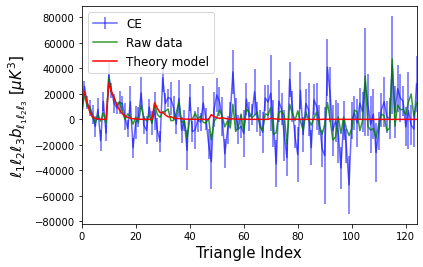

In [22]:
fish_err = np.sqrt(np.diag(np.linalg.inv(fish_b)))
plt.errorbar(np.arange(N_b),weights*b_est,yerr=weights*fish_err,label='CE',c='b',alpha=0.6)
plt.errorbar(np.arange(N_b),weights*b_ideal_raw,label='Raw data',c='g',alpha=0.8)
if include_synthetic_b:
    plt.errorbar(np.arange(N_b),weights*bl_model,label='Theory model',c='r')
else:
    plt.errorbar(np.arange(N_b),0.*weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

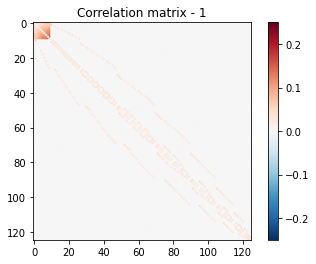

In [23]:
corr_fish_b = fish_b/np.sqrt(np.outer(np.diag(fish_b),np.diag(fish_b)))
v = 0.25
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation matrix - 1")
plt.colorbar();

### Iterate over multiple datasets

In [24]:
inv_fish = np.linalg.inv(fish_b)

### Generate b_1 simulations
sim_Q_b_alpha_map = []
for ii in range(N_it):
    if (ii+1)%5==0: print("Precomputing b_1 piece from simulation %d"%(ii+1))
    # Generate simulations matching true data
    alpha_lm = to_lm(generate_data(seed=10000+ii,add_B=include_synthetic_b))
    Wh_alpha_lm = to_lm(mask*to_map(safe_divide(alpha_lm,Cl_th_lm+Nl_th_lm)))
    sim_Q_b_alpha_map.append([to_map(Wh_alpha_lm*ell_bins[bin1]) for bin1 in range(Nl)])

Precomputing b_1 piece from simulation 5
Precomputing b_1 piece from simulation 10
Precomputing b_1 piece from simulation 15
Precomputing b_1 piece from simulation 20


In [25]:
b_ests = []
b_ests_raw = []
for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    raw_data = generate_data(jj,include_synthetic_b)

    # Mask the map
    data = raw_data*mask
    Wh_data = mask*applySinv(data)
    
    #### Compute Q_b terms
    Wh_data_lm = to_lm(Wh_data)
    Q_b_map = [to_map(Wh_data_lm*ell_bins[bin1]) for bin1 in range(Nl)]
    
    ### Compute b_3 part of cubic estimator
    b3_num = np.zeros(N_b)
    index = 0
    if jj==0: print("Computing b_3 piece")
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin2,Nl):
                # skip bins outside the triangle conditions
                if not check_bin(bin1,bin2,bin3): continue

                # compute numerators
                b3_num[index] = A_pix*np.sum(Q_b_map[bin1]*Q_b_map[bin2]*Q_b_map[bin3])/sym_factor[index]
                index +=1 

    ### Compute b_1 part of cubic estimator, averaging over simulations
    if jj==0: print("Computing b_1 piece")
    b1_num = np.zeros(N_b)
    for ii in range(N_it):
        
        # Iterate over bins
        index = 0
        for bin1 in range(Nl):
            for bin2 in range(bin1,Nl):
                for bin3 in range(bin2,Nl):
                    # skip bins outside the triangle conditions
                    if not check_bin(bin1,bin2,bin3): continue

                    # compute numerators, summing over permutations
                    b1_num[index] += -A_pix*np.sum(sim_Q_b_alpha_map[ii][bin1]*sim_Q_b_alpha_map[ii][bin2]*Q_b_map[bin3])/sym_factor[index]/N_it
                    b1_num[index] += -A_pix*np.sum(sim_Q_b_alpha_map[ii][bin1]*Q_b_map[bin2]*sim_Q_b_alpha_map[ii][bin3])/sym_factor[index]/N_it
                    b1_num[index] += -A_pix*np.sum(Q_b_map[bin1]*sim_Q_b_alpha_map[ii][bin2]*sim_Q_b_alpha_map[ii][bin3])/sym_factor[index]/N_it
                    index += 1
    
    this_b_num = b3_num + b1_num
    
    # Compute ideal estimator
    I_map_raw = [to_map(ell_bins[bin1]*safe_divide(to_lm(raw_data),Cl_th_lm+Nl_th_lm)) for bin1 in range(Nl)]
    
    # Combine to find numerator
    if jj==0: print("Computing ideal estimator")
    this_b_num_ideal_raw = []
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl):
            for bin3 in range(bin2,Nl):
                # skip bins outside the triangle conditions
                if not check_bin(bin1,bin2,bin3): continue

                # compute numerators
                this_b_num_ideal_raw.append(A_pix*np.sum(I_map_raw[bin1]*I_map_raw[bin2]*I_map_raw[bin3])/sym_factor[len(this_b_num_ideal_raw)])
    
    b_ests.append(inv_fish@this_b_num)
    b_ests_raw.append(np.asarray(this_b_num_ideal_raw)/b_denom)

Analyzing simulation 1 of 100
Computing b_3 piece
Computing b_1 piece
Computing ideal estimator
Analyzing simulation 11 of 100
Analyzing simulation 21 of 100
Analyzing simulation 31 of 100
Analyzing simulation 41 of 100
Analyzing simulation 51 of 100
Analyzing simulation 61 of 100
Analyzing simulation 71 of 100
Analyzing simulation 81 of 100
Analyzing simulation 91 of 100


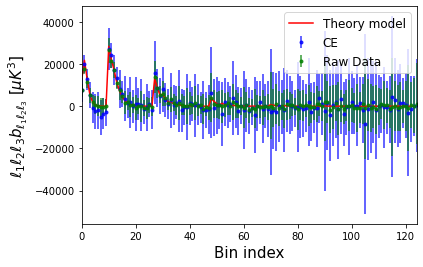

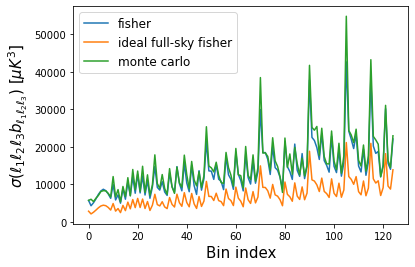

In [26]:
fish_err = np.sqrt(np.diag(np.linalg.inv(fish_b)))
plt.errorbar(np.arange(N_b),weights*np.asarray(b_ests).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='CE',c='b',alpha=0.8)
plt.plot(np.arange(N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(N_b),weights*np.asarray(b_ests_raw).mean(axis=0),yerr=weights*np.asarray(b_ests_raw).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.8,c='g')
plt.xlim([0,N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(N_b),weights*fish_err,label='fisher')
f_sky = np.mean(mask)
plt.plot(np.arange(N_b),weights*np.sqrt(1./b_denom),label=r'ideal full-sky fisher')
plt.plot(np.arange(N_b),weights*np.asarray(b_ests).std(axis=0),label='monte carlo')
plt.xlabel(r'Bin index',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);